In [ ]:
https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html 

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt", filename="train.txt") 


In [ ]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
f = open('train.txt', 'r')
tagged_sentences = []
sentence = [] 

In [ ]:
for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
          tagged_sentences.append(sentence)
          sentence = [] 
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

In [ ]:
# 코드로 형식 지정됨
splits = "EU NNP B-NP B-ORG"
splits = splits.split(" ")
re.sub(r'\n', '', splits[-1]) #r 붙히는 이유! : \n 을 그대로 인식하라는 뜻

In [ ]:
tagged_sentences

In [ ]:
len(tagged_sentences)

In [ ]:
tagged_sentences[0]

In [ ]:
A = [1,2,3]
B = ['A','B','C'] 

In [ ]:
for i in zip(A,B):
    print(i) 

In [ ]:
re_L = list(zip(A,B))
re_L 

In [ ]:
a, b= zip(*re_L) # *을 붙이면 3개 이상 묶인다.

In [ ]:
for tagged_sentence in tagged_sentences:
  print(tagged_sentence)
  sentence, tag_info=zip(*tagged_sentence)
  break

In [ ]:
sentence

In [ ]:
tag_info

In [ ]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 14,041개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다. 


In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences))) 

In [ ]:
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show() 

토큰화 인코딩

In [ ]:
max_words = 4000

In [ ]:
src_tokenizer = Tokenizer(num_words = max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

In [ ]:
# src_tokenizer.word_counts
src_tokenizer.word_index

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [ ]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size)) 

In [ ]:
src_tokenizer.texts_to_sequences(sentences) #수치로 변환

In [ ]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags) 

In [ ]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [ ]:
decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded)) 

In [ ]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
# X_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
# y_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자0으로 채움.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777) 

In [ ]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size) 

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape)) 

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from keras.optimizers import Adam

In [ ]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True))) 
model.add(Dense(tag_size, activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy']) 
hist = model.fit(X_train, y_train, batch_size=128, epochs=8,  validation_data=(X_test, y_test)) 

In [37]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1])) 

88/88 [==============================] - 1s 6ms/step - loss: 0.0329 - accuracy: 0.9570

 테스트 정확도: 0.9570


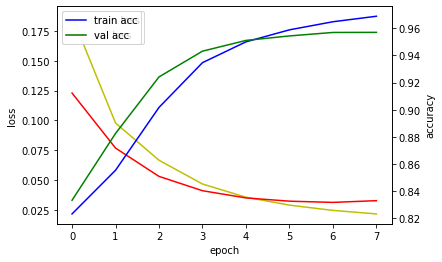

In [39]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()